# データの準備

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(file_path, tokenizer = None):
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    if tokenizer == None :
        tokenizer = Tokenizer(filters="")
        tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

x_train = np.load('./data/x_train.npy')
x_valid = np.load('./data/x_valid.npy')

# 読み込み＆Tokenizerによる数値化
y_train, tokenizer_train = load_data('./data/y_train.txt')
y_valid, _ = load_data('./data/y_valid.txt', tokenizer_train)

vocab_size = len(tokenizer_train.word_index) + 1

# パディング
y_train = pad_sequences(y_train, padding='post')
y_valid = pad_sequences(y_valid, padding='post')

caption_len = len(y_train[0])

/Users/yogai/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# モデル構築

## encoder

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Flatten, Lambda
from tensorflow.keras.applications.vgg16 import VGG16

K.clear_session()

encoder_input = Input(shape=(224, 224, 3))
encoder_input_normalized = Lambda(lambda x: x / 255.)(encoder_input) # [0, 255) -> [0, 1)
encoder = VGG16(weights='imagenet', include_top=False, input_tensor=encoder_input_normalized)

# パラメータを固定
for layer in encoder.layers:
    layer.trainable = False

# CNNの出力
u = Flatten()(encoder.output)

Instructions for updating:
Colocations handled automatically by placer.


## decoder

In [3]:
from tensorflow.keras.layers import Dense, Embedding, LSTM

emb_dim = 128
hid_dim = 128

# LSTMの初期状態
decoded_states = [Dense(hid_dim)(u), Dense(hid_dim)(u)] # h_0、c_0 に対応

# 層の定義
decoder_input = Input(shape=(caption_len,))
embedding = Embedding(vocab_size, emb_dim, mask_zero=True)
lstm = LSTM(hid_dim, activation='tanh', return_sequences=True, return_state=True)
dense = Dense(vocab_size, activation='softmax')

# 層の接続
decoder_embedded = embedding(decoder_input)
decoder_output, _, _ = lstm(decoder_embedded, initial_state=decoded_states) # 第2、3戻り値(最終ステップのh、c)は無視
decoder_pred = dense(decoder_output)

## モデル化

In [4]:
from tensorflow.keras.models import Model

model = Model([encoder_input, decoder_input], decoder_pred)
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

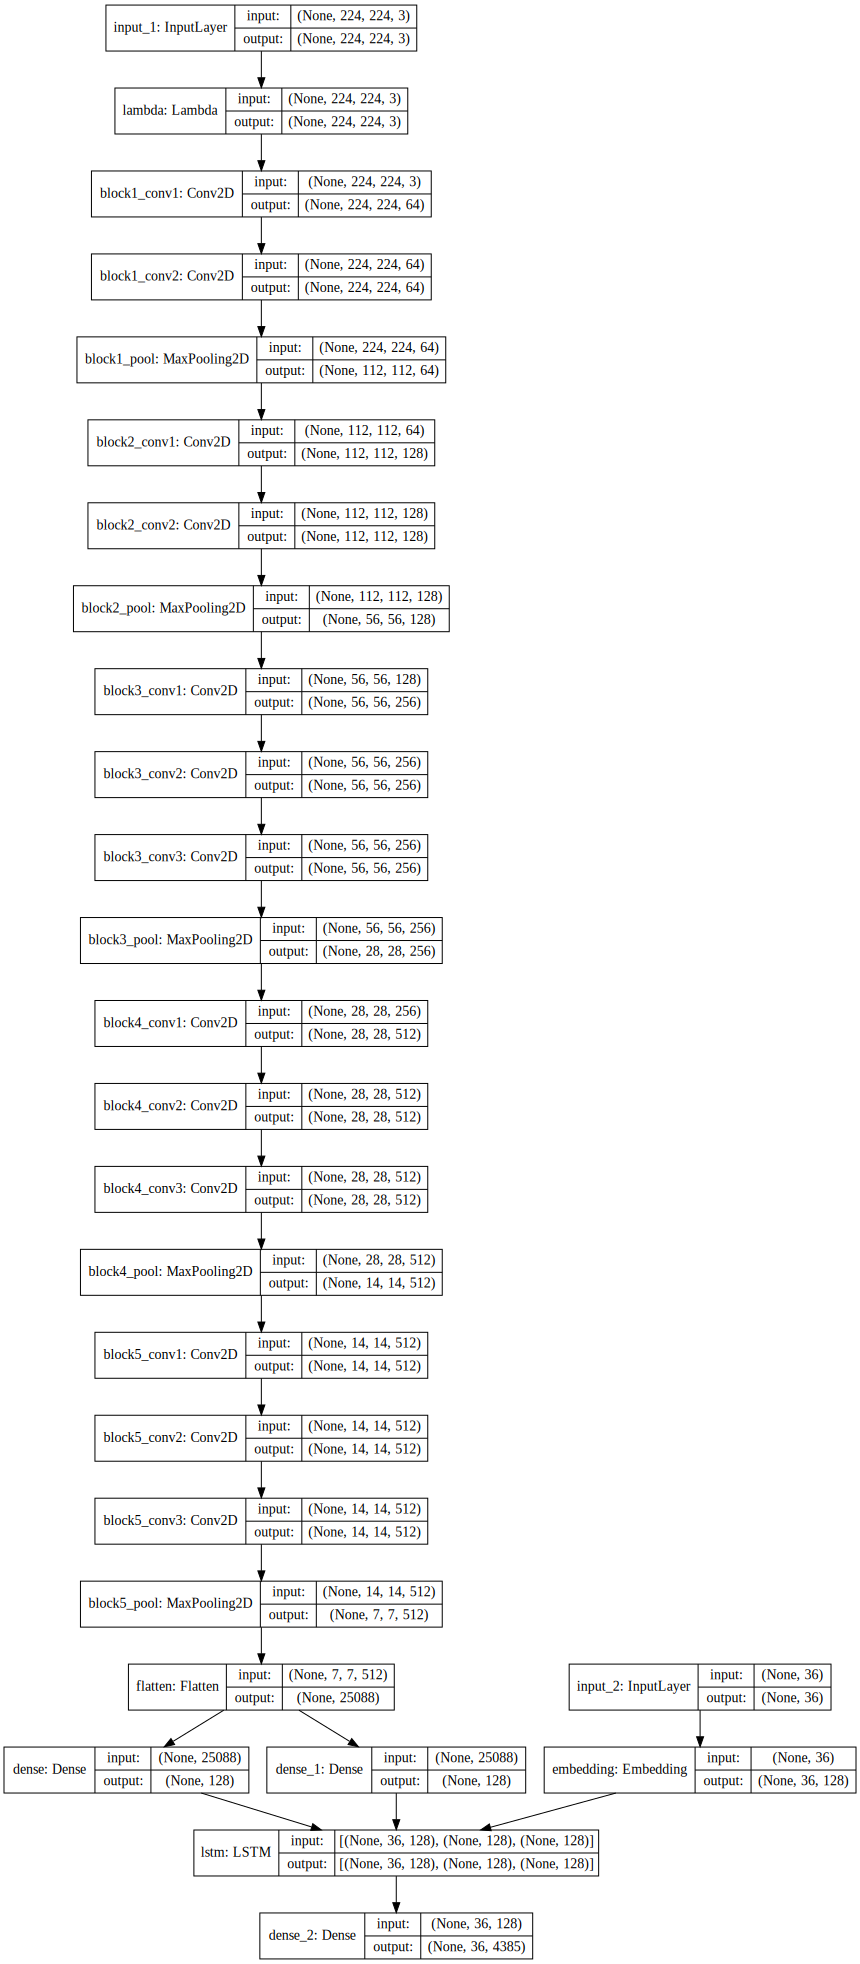

In [5]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# モデルの学習

In [ ]:
import numpy as np

train_target = np.hstack((y_train[:, 1:], np.zeros((len(y_train),1), dtype=np.int32)))

model.fit([x_train, y_train], np.expand_dims(train_target, -1), batch_size=64, epochs=2, verbose=1, validation_split=0.2)

# モデルによる生成

In [7]:
# サンプリング用（生成用）のモデルを作成

# 符号化器（学習時と同じ構成、学習したレイヤーを利用）
encoder_model = Model(encoder_input, decoded_states)

# 復号化器
decoder_states_inputs = [Input(shape=(hid_dim,)), Input(shape=(hid_dim,))] # decorder用lstmの初期状態指定用(h_t、c_t)

decoder_input = Input(shape=(1,))
decoder_embedded = embedding(decoder_input) # 学習済みEmbeddingレイヤーを利用
decoder_output, *decoder_states = lstm(decoder_embedded, initial_state=decoder_states_inputs) # 学習済みLSTMレイヤーを利用
decoder_pred = dense(decoder_output) # 学習済みDenseレイヤーを利用

decoder_model = Model([decoder_input] + decoder_states_inputs, [decoder_pred] + decoder_states)

In [8]:
def decode_sequence(input_image, bos_eos, max_output_length = 100):
    states = encoder_model.predict(input_image)

    target_seq = np.array(bos_eos[0])  # bos_eos[0]="<s>"に対応するインデックス
    output_seq= bos_eos[0]
    
    while True:
        token_dist, *states = decoder_model.predict([target_seq] + states)
        sampled_token_index = [np.argmax(token_dist[0, -1, :])]
        output_seq += sampled_token_index
        
        if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
            break

        target_seq = np.array(sampled_token_index)

    return output_seq

<s> a man with a man in a kitchen . </s>


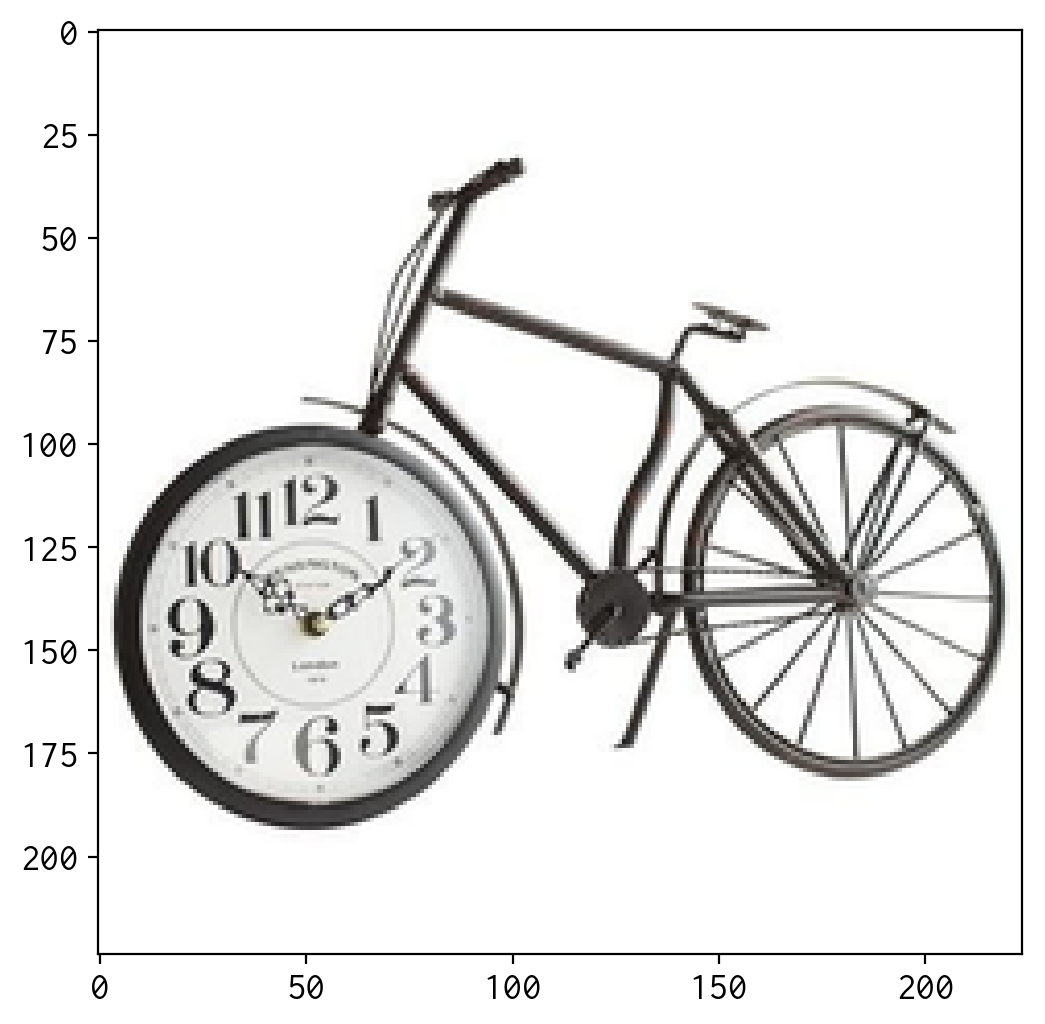

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

bos_eos = tokenizer_train.texts_to_sequences(["<s>", "</s>"])
detokenizer_train = dict(map(reversed, tokenizer_train.word_index.items()))

x_test = np.array(x_valid[:1])

y_pred = decode_sequence(x_test, bos_eos)

print(' '.join([detokenizer_train[i] for i in y_pred]))

plt.imshow(x_test[0])

# パラメータの保存

In [13]:
import os

def save_model(model, name):
    data_dir = 'data'
    if not os.path.isdir(data_dir):
        os.makedirs(data_dir)
    result_dir = os.path.normpath(data_dir)
    model.save_weights(os.path.join(result_dir, name + '_model.h5'))
    
def load_weight(model, name):
    data_dir = 'data'
    result_dir = os.path.normpath(data_dir)
    weight_file = os.path.join(result_dir, name + '_model.h5')
    model.load_weights(weight_file)
    return model

In [14]:
# save model
save_model(model, 'image2text')

In [ ]:
# load weight
if os.path.exists('data/image2text_model.h5'):
    model = load_weight(model, 'image2text')